#  Solitaire
*by Alejandro Suárez Hernández*

## Introduction

This notebook gathers experiments on the Solitaire game. We have modeled the rules in MiniZinc using channeling between two views of the problem ("stack" view and "positions" view) to conveniently express the problem constraints.

The game has mainly two rules:
1. Only the top card of the heaps may be removed to put it in the stack.
1. Consecutive cards in the stack must have ranks at a distance of *exactly* 1 (ranks are viewed as a ring, so rank m and rank 1 are neighbours).

We propose two models. In the first (*mzn/solitaire.mzn*), we enforce the second of these rules by storing the differences between consecutive card numbers of the stack. The domain of the difference variables is the set of valid differences in virtue to the second rule, so this automatically guarantees the accomplishment of the constraint. The second model (*mzn/solitaire_alt.mzn*) enforces the second rule by using the *table* constraint and a look-up table of neighbours, inferred from the input parameters by MiniZinc. This is, the lookup table is defined with built-in MiniZinc functions in the model, so that the data files do not have be bloated with pre-computed auxiliary data structures. Both models are generic: this is, the number of suits, cards per suit, heap size and first card of the stack are parameters, so one can actually build instances for other decks (e.g. the simplified Spanish deck) and change the initial layout of the heaps. For the sake of simplicity, we focus exclusively on the second model, since our exploratory analysis suggests that it outperforms the first one by a significant margin.

Our model(s) come with some *.dzn* files (all in the *mzn* folder), so the interested reader can execute MiniZinc with our model directly, without requiring the random generator. These data files also show the expected parameters of our model.

We test the performance of the *Gecode* and *Chuffed* solvers with our model against random Solitaire instances.  Our random generator returns a dict with the *.dzn* data. We use the *Pymzn* library to interface with MiniZinc and then gather the results.

## Methodology

For illustrative purposes, we start with an example problem (created by our random generator) and solve it using both Gecode and Chuffed.

Then, we generate random instances from the French and the Spanish deck, comparing the performances of Gecode and Chuffed. It is our purpose to compare the coverage and the solving time in the following scenarios:
1. Gecode - French deck
1. Chuffed - French deck
1. Gecode - Spanish deck
1. Chuffed - Spanish deck

We will do so executing MiniZinc against 200 random instances for each scenario (the seeds are fixed so the results are reproducible and comparable within the same deck), registering whether their solution has been found and the solving time. In all the cases we will fix the timeout to 60 seconds.


In [1]:
%matplotlib inline

from tqdm import tqdm_notebook

from IPython.display import display, HTML

import solitaire
import pickle as pkl
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 5]

def display_big(text, font_size=28):
    text = text.replace("\n", "<br>")
    display(HTML('<span style="font-size: {}pt; line-height: 1.5em;">{}</span>'.format(font_size, text)))


def display_problem(problem, layout_size=28):
    print("Bottom:")
    display_big(solitaire.pty_card(problem["bottom"]))
    print("Initial layout:")
    display_big(solitaire.pty_layout(problem), font_size=layout_size)
    
def display_result(result, m=13):
    if result["timeout"]:
        print("Timeout after {:.02f}s".format(result["elapsed"]))
    elif not result["stack"]:
        print("Unsatisfiable. Elapsed: {:.02f}s".format(result["elapsed"]))
    else:
        print("Stack:")
        display_big(solitaire.pty_stack(result["stack"], m))
        print("Elapsed: {:.02f}s".format(result["elapsed"]))
        
def run_experiment(N, solver="gecode", timeout=300, problem_args={}, cache=None, load=False):
    """
    Creates N random instances and tries to solve them with the given solder. Returns array
    of results. Allows caching the results in a file so they do not have to be recomputed
    (in some cases this can take a lot of time).
    """
    if load:
        assert cache is not None
        print("Loading {}...".format(cache))
        with open(cache+".pkl", "rb") as f:
                results = pkl.load(f)
                print("Loaded.")
    else:
        solved = []
        timeouts = []
        unsatisfiable = []
        for i in tqdm_notebook(range(N)):
            problem = solitaire.generate(rng_seed=i, **problem_args)
            result = solitaire.solve(problem, solver_name=solver,
                                     exec_args={"timeout": timeout})
            if result["stack"]:
                solved.append(result)
            elif result["timeout"]:
                timeouts.append(result)
            else:
                unsatisfiable.append(result)
            print('#Solved: {}\t#Timeouts: {}\t#Unsatisfiable: {}'.format(
                len(solved), len(timeouts), len(unsatisfiable)), end='\r')
        results = {
            "solved": solved,
            "timeouts": timeouts,
            "unsatisfiable": unsatisfiable
        }
        if cache is not None:
            with open(cache+".pkl", "wb") as f:
                pkl.dump(results, f)
    return results

def plot_results(results, solver, deck, filename=None):
    solved = results["solved"]
    unsatisfiable = results["unsatisfiable"]
    timeouts = results["timeouts"]
    elapsed_solved = [s["elapsed"] for s in solved]
    elapsed_unsat = [us["elapsed"] for us in unsatisfiable]
    data_pie = [len(solved), len(unsatisfiable), len(timeouts)]
    # Pie chart
    plt.subplot(1,2,1)
    labels = ['Solved', 'Unsat', 'Timeout']
    plt.pie(data_pie, labels=labels, autopct='%1.1f%%', colors=["#a9f971", "#ff474c", "#90e4c1"])
    plt.axis("equal")
    # Histogram
    plt.subplot(1,2,2)
    plt.grid("on")
    plt.hist([elapsed_solved, elapsed_unsat], rwidth=0.5, bins=15, stacked=True)
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency")
    plt.legend(("Satisfiable", "Unsatisfiable"))
    plt.suptitle("{} vs {} deck, N=200, #solved={}, #unsat={}, #timeout={}".format(solver,
                                                                                   deck,
                                                                                   *data_pie))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    if filename is None:
        plt.show()
    else:
        plt.savefig(filename)

## Experiments

### French deck

Our experiments will begin with the French deck. Sorted cards in the French deck:

In [2]:
cards = ' '.join(map(solitaire.pty_card, range(1,53)))
display_big(cards)

#### Example: solving a single random problem

Example of randomly generated problem:

In [3]:
problem = solitaire.generate(rng_seed=43)
display_problem(problem, layout_size=18)

Bottom:


Initial layout:


Solving the problem with different solvers and parameters:

In [4]:
# This one gives timeout
result = solitaire.solve(problem, solver_name="gecode", exec_args={"timeout": 1})
display_result(result)

Timeout after 1.08s


In [5]:
result = solitaire.solve(problem, solver_name="gecode", exec_args={"timeout": 300})
display_result(result)

Stack:


Elapsed: 4.70s


In [6]:
result = solitaire.solve(problem, solver_name="chuffed", exec_args={"timeout": 300})
display_result(result)

Stack:


Elapsed: 0.07s


#### Gecode vs French deck

Next, we generate 200 instances and (try to) solve them with Gecode. We will divide the results in three categories: solved problems; timeouts; and *proven* unsatisfiable instances.

In [7]:
# WARNING! This takes a LOT of time. We recommend loading the cached .pkl.

results_gecode_french = run_experiment(200, solver="gecode", timeout=60, problem_args={},
                                       cache="results_gecode_french", load=True)

Loading results_gecode_french...
Loaded.


Avg. time (sat+unsat): 10.55s


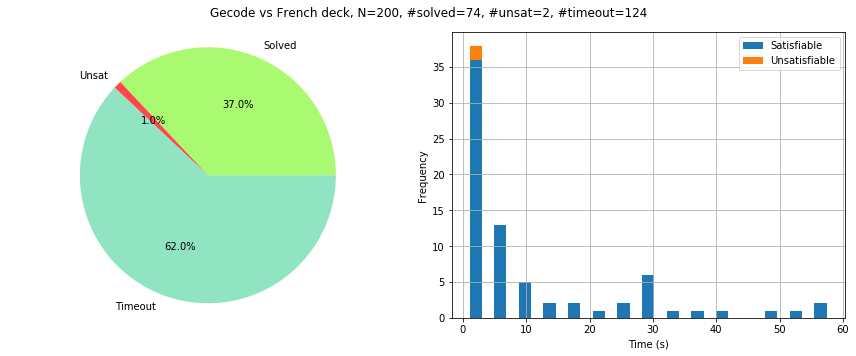

In [8]:
plot_results(results_gecode_french, "Gecode", "French", "results_gecode_french.pdf")

avg_time_gecode_french = sum([r["elapsed"] for r in results_gecode_french["solved"]])
avg_time_gecode_french += sum([r["elapsed"] for r in results_gecode_french["unsatisfiable"]])
avg_time_gecode_french /= len(results_gecode_french["solved"]) + len(results_gecode_french["unsatisfiable"])

print("Avg. time (sat+unsat): {:.02f}s".format(avg_time_gecode_french))

The results are rather underwhelming. Gecode is not able to solve (either proving unsatisfability or finding a solution) more than half of the problems.

Almost all the solved instances (and the ones that have been proven unsatisfiable) by Gecode require a rather low solving time. This suggests that some instances are easier than others and that Gecode is able to solve just the easiests ones in the given time.

#### Chuffed vs French deck

Same procedure, but with Chuffed:

In [9]:
results_chuffed_french = run_experiment(200, solver="chuffed", timeout=60, problem_args={},
                                       cache="results_chuffed_french", load=True)

Loading results_chuffed_french...
Loaded.


Avg. time (sat+unsat): 0.39s


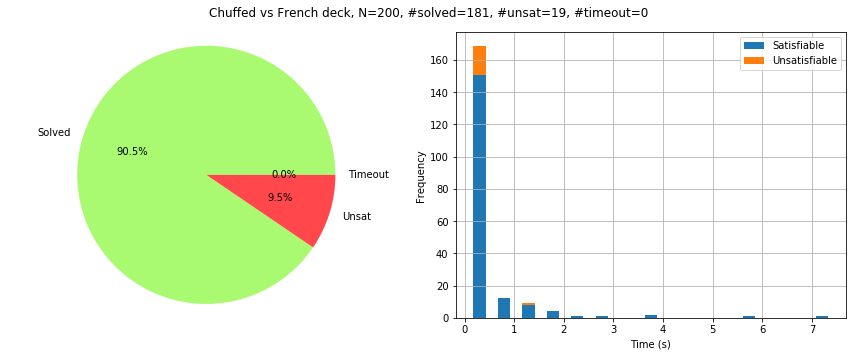

In [10]:
plot_results(results_chuffed_french, "Chuffed", "French", "results_chuffed_french.pdf")

avg_time_chuffed_french = sum([r["elapsed"] for r in results_chuffed_french["solved"]])
avg_time_chuffed_french += sum([r["elapsed"] for r in results_chuffed_french["unsatisfiable"]])
avg_time_chuffed_french /= len(results_chuffed_french["solved"]) + len(results_chuffed_french["unsatisfiable"])

print("Avg. time (sat+unsat): {:.02f}s".format(avg_time_chuffed_french))

Chuffed improves quite significantly over the previous results. Now the coverage is 100% (i.e., all the instances have been either solved or proven unsatisfiable).

The solving time is always below 10 seconds (well below the timeout) and, most of the time, lower than 1 second.

### (Simplified) Spanish deck

The simplified Spanish deck has 4 suits and 40 cards (48 from the complete set minus 2 per suit). The simplified Spanish deck has much less cards than the French deck. Therefore, it is only natural to think that the experiments in this section will take considerably less time.

The sorted cards are (using the symbols from the French deck because Unicode does not have symbols for the Spanish deck yet):

In [11]:
cards = ' '.join(map(lambda c: solitaire.pty_card(c, m=10), range(1,41)))
display_big(cards)

#### Example: solving a single random problem

Example of randomly generated problem:

In [12]:
problem = solitaire.generate(rng_seed=43, m=10)
display_problem(problem)

Bottom:


Initial layout:


Solving the problem with different solvers and parameters:

In [13]:
result = solitaire.solve(problem, solver_name="gecode", exec_args={"timeout": 300})
display_result(result, 10)

Stack:


Elapsed: 0.10s


In [14]:
result = solitaire.solve(problem, solver_name="chuffed", exec_args={"timeout": 300})
display_result(result, 10)

Stack:


Elapsed: 0.06s


This small example supports our initial guess: the execution with Gecode was much faster. This has to be further validated in the next sections.

#### Gecode vs Spanish deck

In [15]:
# WARNING! This takes a LOT of time. We recommend loading the cached .pkl.

results_gecode_spanish = run_experiment(200, solver="gecode", timeout=60, problem_args={"m":10},
                                        cache="results_gecode_spanish", load=True)

Loading results_gecode_spanish...
Loaded.


Avg. time (sat+unsat): 3.67s


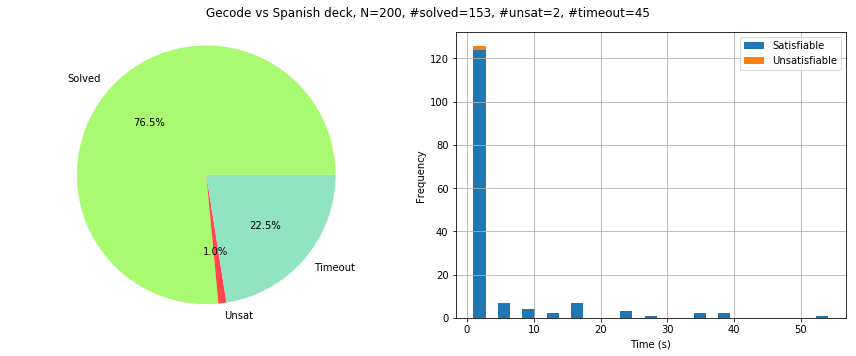

In [16]:
plot_results(results_gecode_spanish, "Gecode", "Spanish", "gecode_spanish.pdf")

avg_time_gecode_spanish = sum([r["elapsed"] for r in results_gecode_spanish["solved"]])
avg_time_gecode_spanish += sum([r["elapsed"] for r in results_gecode_spanish["unsatisfiable"]])
avg_time_gecode_spanish /= len(results_gecode_spanish["solved"]) + len(results_gecode_spanish["unsatisfiable"])

print("Avg. time (sat+unsat): {:.02f}s".format(avg_time_gecode_spanish))

Indeed, now that the problem size is considerably smaller, the results have improved considerable with respect to the French deck/Gecode scenario. However, the coverage is not complete.

#### Chuffed vs Spanish deck

In [17]:
results_chuffed_spanish = run_experiment(200, solver="chuffed", timeout=60, problem_args={"m":10},
                                        cache="results_chuffed_spanish", load=True)

Loading results_chuffed_spanish...
Loaded.


Avg. time (sat+unsat): 0.05s


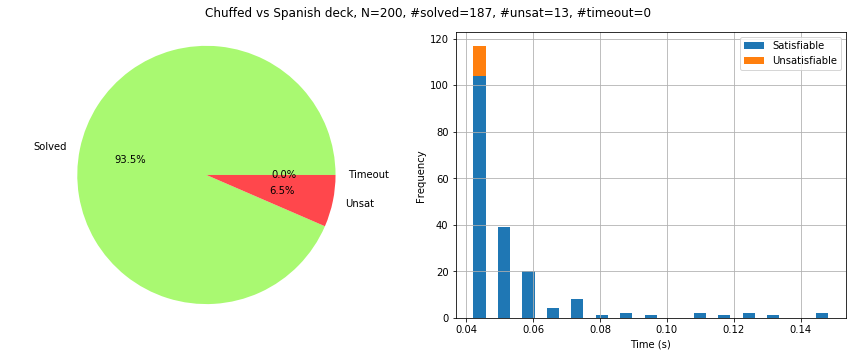

In [18]:
plot_results(results_chuffed_spanish, "Chuffed", "Spanish", "chuffed_spanish.pdf")

avg_time_chuffed_spanish = sum([r["elapsed"] for r in results_chuffed_spanish["solved"]])
avg_time_chuffed_spanish += sum([r["elapsed"] for r in results_chuffed_spanish["unsatisfiable"]])
avg_time_chuffed_spanish /= len(results_chuffed_spanish["solved"]) + len(results_chuffed_spanish["unsatisfiable"])

print("Avg. time (sat+unsat): {:.02f}s".format(avg_time_chuffed_spanish))



## Summary

|    | French deck/Gecode | French deck/Chuffed | Spanish deck/Gecode | Spanish deck/Chuffed |
|----|--------------------|---------------------|---------------------|----------------------|
| %Solved                  | 37.0% | 90.5% | 76.5% | 93.5% |
| %Unsat                   |  1.0% |  9.5% |  1.0% |  6.5% |
| %Timeout                 | 62.0% |  0.0% | 22.5% |  0.0% |
| Avg. time (solved+unsat) | 10.6s |  0.4s |  3.7s |  0.1s |

All the times shown in this table have been obtained with the following specifications: Intel i7-7700HQ @ 2.8GHz and 8GB of DDR4 RAM.

## Conclusions

Clearly, Chuffed outperforms Gecode both in the Solitaire game with the French deck and with the Spanish deck. This is evidenced by the coverage (always complete for Chuffed, and only partial with Gecode) and in the solving time (without considering timeouts): Chuffed requires between 1 and 2 orders of magnitude less time than Gecode.

According to our results, the ratio of solvable vs unsolvable problems of the strategy we use to generate random problems (i.e. random shuffling) is, approximately:
* 9.5 solvable problems per each unsolvable one for the French deck.
* 14.4 solvable problems per unsolvable one for the Spanish deck.

This means that random shuffling is a reasonable strategy for generating solvable solitaire games. Of course, these calculations have been performed using the statistics of the Chuffed solver, that has complete coverage.